# Aiyagari (1994)

In [1]:
import numpy as np
import scipy.linalg as la
import scipy.optimize as opt
from matplotlib import pyplot as plt
from numba import vectorize, jit, njit, float64, prange

### Calibrate the transition probabilities $\pi_{i,j}$

\begin{bmatrix}
    0.9 & 0.1 \\
    x & 1 - x \\
\end{bmatrix}
Solving for x such that: steady-state unemployment rate u = 0.10

In [2]:
def solve_x():
    
    err = lambda x: 0.9 - (0.9 * 0.9 + 0.1 * x)
    #err = lambda x: 0.1 - (0.9 * 0.1 + 0.1 * (1 - x))
    x_guess = 0.6
    x = opt.fsolve(err, x_guess)
    return x

In [3]:
solve_x()

array([0.9])

### Value Function Iteration Construction

In [4]:
### Parameters
beta = 0.96
delta = 0.06
alpha = 0.36
u = 0.1

In [5]:
def solve_kss():
    '''
    k_ss for representative agent model.
    '''
    return (alpha * beta / (1 - beta * (1 - delta))) ** (1 / (1 - alpha))

In [6]:
k_rep_ss = solve_kss()
k_rep_ss

7.211176392599507

In [7]:
N_k = 400
k_min = 0.001
k_max = 40
k_grid = np.linspace(k_min, k_max, N_k)

# Initialize the value function:
V_init1 = np.zeros_like(k_grid)
V_init2 = np.zeros_like(k_grid)

In [8]:
@njit
def get_r(k):
    r = alpha * (k ** (alpha - 1)) * ((1 - u) ** (1 - alpha))
    return r

@njit
def get_w(k):
    w = (1 - alpha) * (k ** alpha) * ((1 - u) ** (-alpha))
    return w

@njit
def U(c):
    return np.log(c)

In [9]:
@njit
def actionvalue_allchoices(k_index, eps_index, V_old1, V_old2, k_bar):
    """
    input:
    k_index: index so that k_grid[index] corresponds to value of capital this period (state)
    V_old: approximation to the value function. V_old[i] approximates V(k_grid[i]).
    
    output:
    action_value: value of all possible state-action pairs.
    """
    k = k_grid[k_index]
    action_value = np.zeros_like(k_grid)
    
    r = get_r(k_bar)
    w = get_w(k_bar)
    
    if eps_index == 1:
        p11 = 0.9
        p12 = 0.1
        c = r * k + w * 1 + (1 - delta) * k - k_grid
        action_value[c <= 0] = -999999
        action_value[c > 0] = U(c[c > 0]) + beta * (p11 * V_old1[c > 0] + p12 * V_old2[c > 0])
    
    if eps_index == 2:
        p21 = 0.9
        p22 = 0.1
        c = r * k + w * 0 + (1 - delta) * k - k_grid
        action_value[c <= 0] = -999999
        action_value[c > 0] = U(c[c > 0]) + beta * (p21 * V_old1[c > 0] + p22 * V_old2[c > 0])
    
    return action_value

In [10]:
@njit
def vf_update(i, eps_index, V_old1, V_old2, k_bar):
    """
    input:
    i: index corresponding to the entry of the value-function vector which is updated
    V_old: value function vector from the previous iteration
    
    output:
    Vi_new: updated value for the value function vector at entry i.
    """
    Vi_new = np.max(actionvalue_allchoices(i, eps_index, V_old1, V_old2, k_bar))
    
    return Vi_new

In [11]:
@njit
def vf_update_iteration(V_old1, V_old2, k_bar):
    """
    input: 
    V_old: array with current approximation of the value function
    
    output:
    V_new: updated approximation of the value function
    """
    V_new1 = np.zeros_like(V_old1)
    V_new2 = np.zeros_like(V_old2)

    for i in range(N_k):
        V_new1[i] = vf_update(i, 1, V_old1, V_old2, k_bar)
        V_new2[i] = vf_update(i, 2, V_old1, V_old2, k_bar)
    
    return V_new1, V_new2

In [12]:
@njit
def solve_value_func_iter(k_bar):
    threshold = 1e-8
    max_iterations = 10000
    plot_interval = 50

    V1 = V_init1.copy()
    V2 = V_init2.copy()

    for iteration in range(max_iterations):
        #print('Iteration: {}'.format(iteration + 1))

        V_new1, V_new2 = vf_update_iteration(V1, V2, k_bar)
        
        difference1 = np.amax(np.abs(V_new1 - V1))
        difference2 = np.amax(np.abs(V_new2 - V2))

        V1 = V_new1
        V2 = V_new2
        
        #print(difference1, difference2)
        
        if difference1 < threshold and difference2 < threshold:
            #print('Converged after iteration {}'.format(iteration + 1))
            break

    return V1, V2

In [13]:
k_guess = k_rep_ss
V1, V2 = solve_value_func_iter(k_guess)

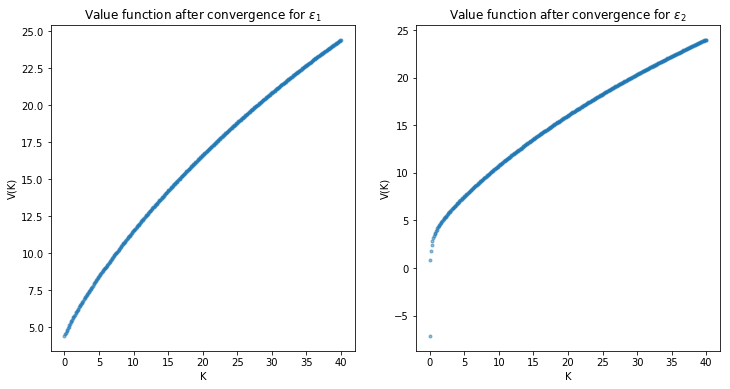

In [14]:
fig, axes = plt.subplots(1, 2, figsize=(12,6))
        
axes[0].scatter(k_grid, V1, alpha=0.5, marker='.')
axes[0].set_xlabel("K")
axes[0].set_ylabel("V(K)")
axes[0].set_title('Value function after convergence for $\epsilon_1$')

axes[1].scatter(k_grid, V2, alpha=0.5, marker='.')
axes[1].set_xlabel("K")
axes[1].set_ylabel("V(K)")
axes[1].set_title('Value function after convergence for $\epsilon_2$')

plt.show()

In [15]:
@njit
def extract_policy(V1, V2, k_bar):
    """
    input:
    V: value function array
    
    output:
    p: polcy function array
    """
    p_k1 = np.zeros_like(k_grid)
    p_k2 = np.zeros_like(k_grid)
    
    for i in range(len(V1)): 
        p_k1[i] = k_grid[np.argmax(actionvalue_allchoices(i, 1, V1, V2, k_bar))]
        p_k2[i] = k_grid[np.argmax(actionvalue_allchoices(i, 2, V1, V2, k_bar))]
    
    return p_k1, p_k2

In [16]:
p_k1, p_k2 = extract_policy(V1, V2, k_guess)

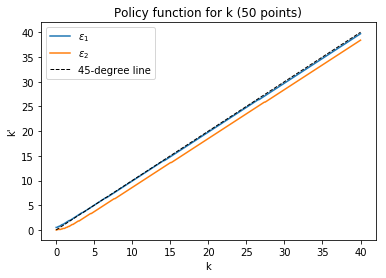

In [17]:
plt.plot(k_grid, p_k1, '-', label = '$\epsilon_1$')
plt.plot(k_grid, p_k2, '-', label = '$\epsilon_2$')
plt.plot(k_grid, k_grid, color='black', linewidth=1, linestyle='--',
                 label='45-degree line')
plt.xlabel('k')
plt.ylabel("k'")
plt.title("Policy function for k (50 points)")
plt.legend(loc='upper left')
plt.show()

### Solving steady-state equilibrium value of aggregate capital $\bar{k}^*$

#### Simulating $\epsilon_t$ and $k_t$
Based on Transition Probability:
\begin{bmatrix}
    0.9 & 0.1 \\
    0.9 & 0.1 \\
\end{bmatrix}

In [18]:
def simulate_eps(T):
    
    np.random.seed(30)
    eps_sim = np.random.uniform(0, 1, T)
    eps_sim[0] = 1
    
    for t in range(1, T):
        if eps_sim[t-1] == 1:
            if  eps_sim[t] < 0.9:
                eps_sim[t] = 1
            else:
                eps_sim[t] = 2

        else:
            if eps_sim[t] < 0.9:
                eps_sim[t] = 1
            else:
                eps_sim[t] = 2
                
    return eps_sim

In [19]:
def simulate_k(p_k1, p_k2, eps_sim, T, plot=True):
    
    k_sim = np.zeros(T)
    k_sim[0] = k_grid[100]
    
    for t in range(1, T):
        k_i = np.where(k_grid == k_sim[t-1])[0][0]
        
        if eps_sim[t-1] == 1:
            k_sim[t] = p_k1[k_i]
        else:
            k_sim[t] = p_k2[k_i]

    if plot:
        fig, axes = plt.subplots(1, 2, figsize=(10,4))
        
        axes[0].scatter(np.linspace(1, T, T), k_sim, alpha=0.5, marker='.')
        axes[0].set_xlabel("Simulation Number")
        axes[0].set_ylabel("K")
        
        axes[1].hist(k_sim, bins=30)
        axes[1].set_xlabel("K")
        axes[1].set_ylabel("Frequency")
        
        plt.suptitle("Simulation of K")
        plt.show()
    
    return k_sim

In [20]:
def compute_k_bar(k_sim):
    '''
    We divide by number of simulation because we assume 
    that each simulation value of k represents one agent in economy
    out of measure 1 unit interval.
    '''
    return np.sum(k_sim) / len(k_sim)

#### Solving $\bar{k}^*$ with bisection method
Reference to bisection method: https://steemit.com/mathematics/@dkmathstats/the-bisection-method-with-python-code

In [21]:
def update_k_bar(k_bar_old, T):
    
    V1, V2 = solve_value_func_iter(k_bar_old)
    p_k1, p_k2 = extract_policy(V1, V2, k_bar_old)

    eps_sim = simulate_eps(T)
    k_sim = simulate_k(p_k1, p_k2, eps_sim, T, plot=True)
    k_bar_new = compute_k_bar(k_sim)
    return k_bar_new

In [22]:
def k_bar_err(k_bar_old, T):
    
    k_bar_new = update_k_bar(k_bar_old, T)
    diff = k_bar_new - k_bar_old
    return diff

In [23]:
def solve_k_bar(k_a, k_b, T):
    
    threshold = 1e-5
    max_iterations = 10000
    
    print('k_a error', k_bar_err(k_a, T))
    print('k_b error', k_bar_err(k_b, T))
    
    if k_bar_err(k_a, T) * k_bar_err(k_b, T) > 0:
        return "k_a and k_b not valid for bisection method."
    
    else:
        for iteration in range(max_iterations):
            print("iteration :", iteration)
            
            k_mid = (k_a + k_b) / 2
            print('mid_value :', k_mid)
            
            if (k_b - k_a) / 2 < threshold:
                return k_mid
            
            k_bar_err_mid = k_bar_err(k_mid, T)
            if k_bar_err_mid == 0:
                return k_mid
            
            elif k_bar_err(k_a, T) * k_bar_err_mid < 0:
                k_b = k_mid
            
            else: 
                k_a = k_mid
            
            iteration += 1
        
        return k_mid

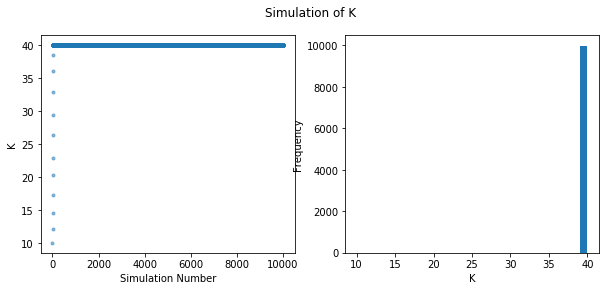

k_a error 38.98204556165413


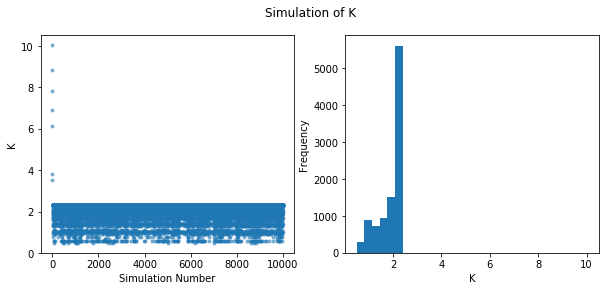

k_b error -18.058356787969924


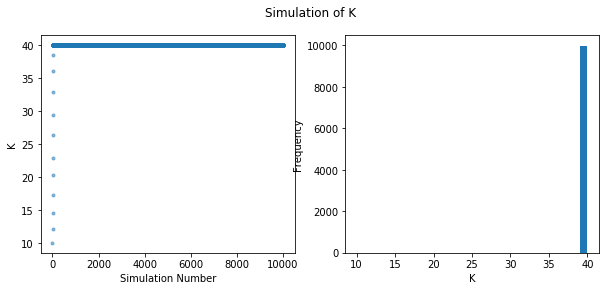

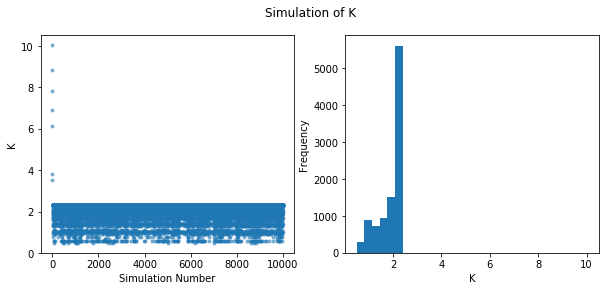

iteration : 0
mid_value : 10.5


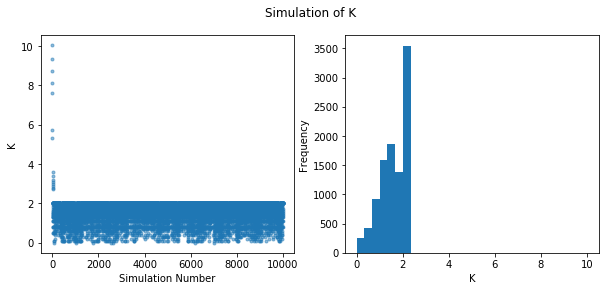

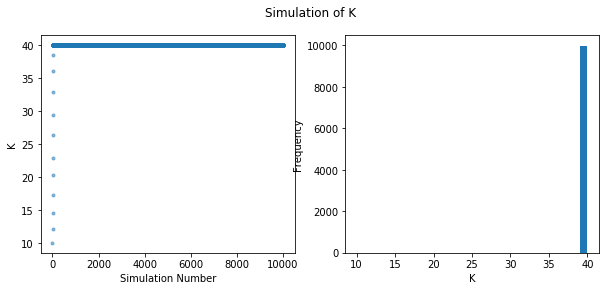

iteration : 1
mid_value : 5.75


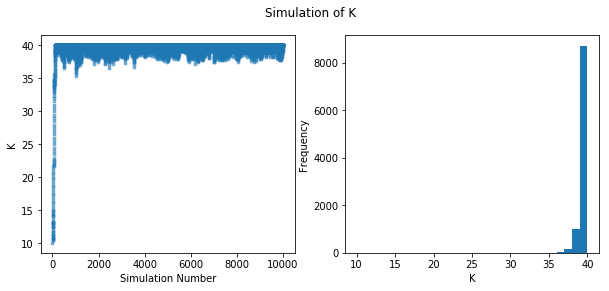

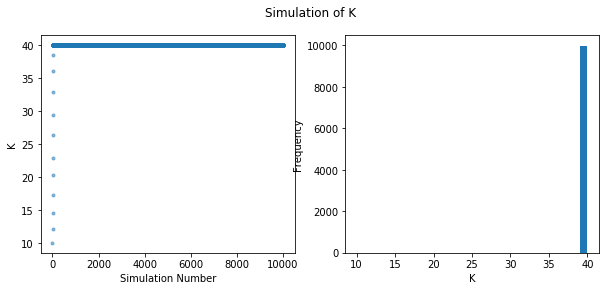

iteration : 2
mid_value : 8.125


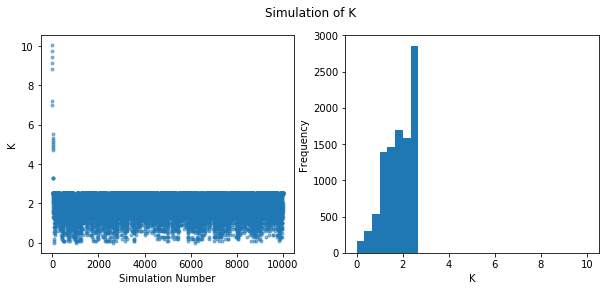

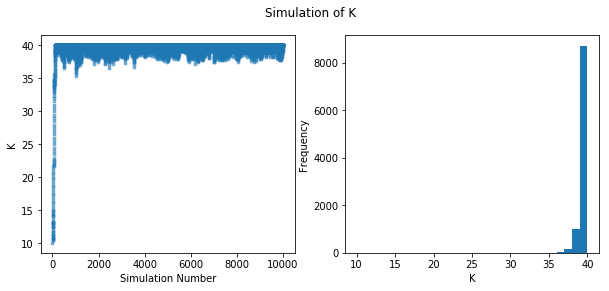

iteration : 3
mid_value : 6.9375


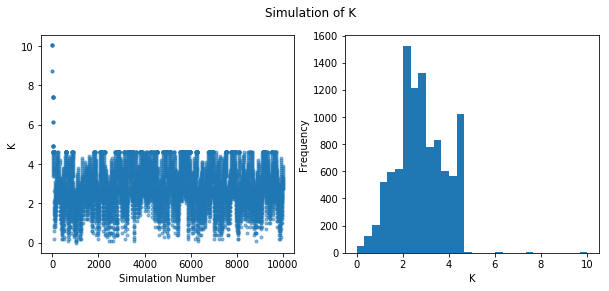

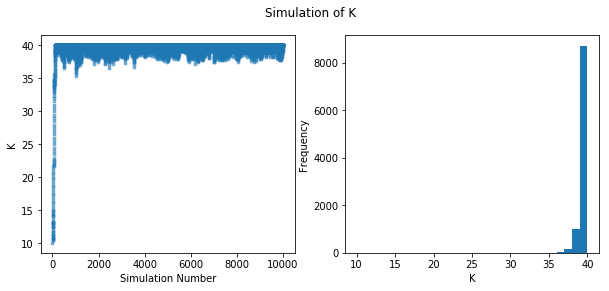

iteration : 4
mid_value : 6.34375


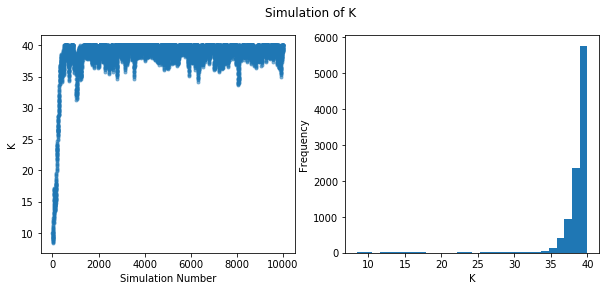

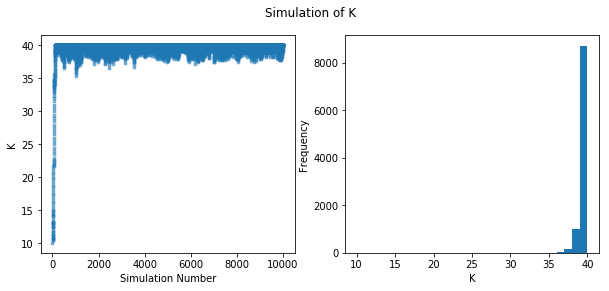

iteration : 5
mid_value : 6.640625


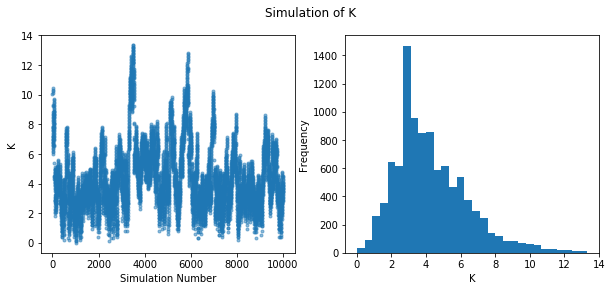

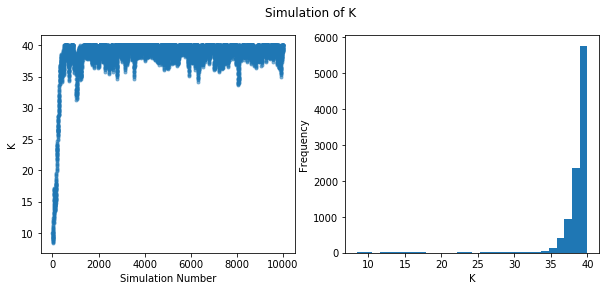

iteration : 6
mid_value : 6.4921875


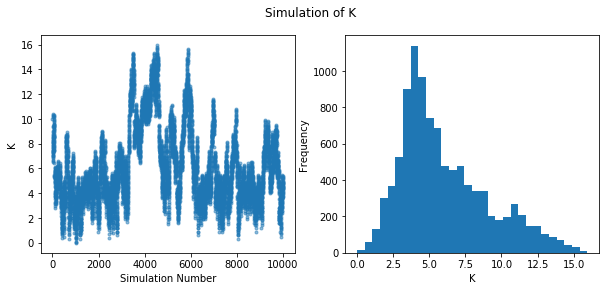

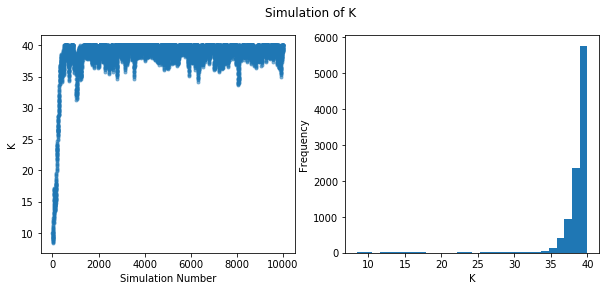

iteration : 7
mid_value : 6.41796875


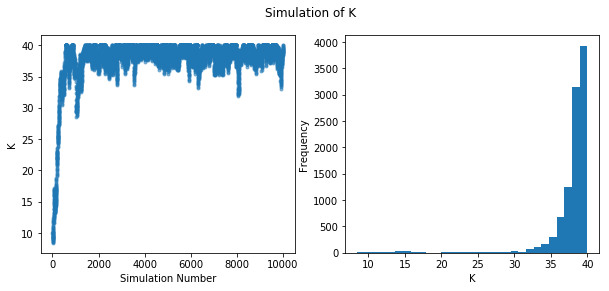

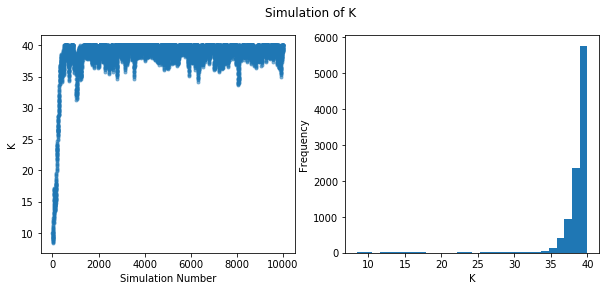

iteration : 8
mid_value : 6.455078125


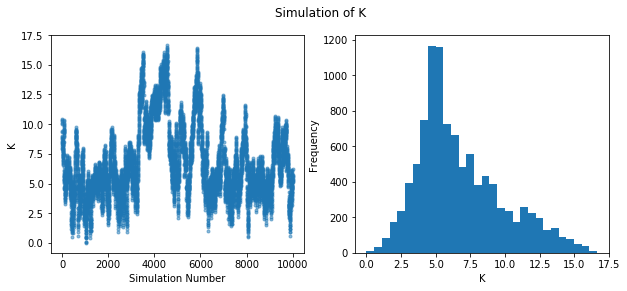

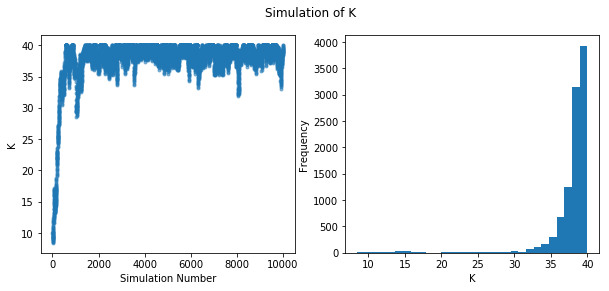

iteration : 9
mid_value : 6.4736328125


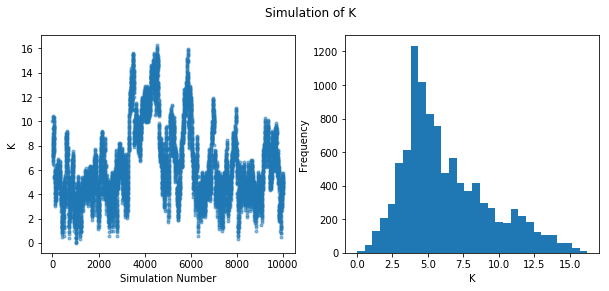

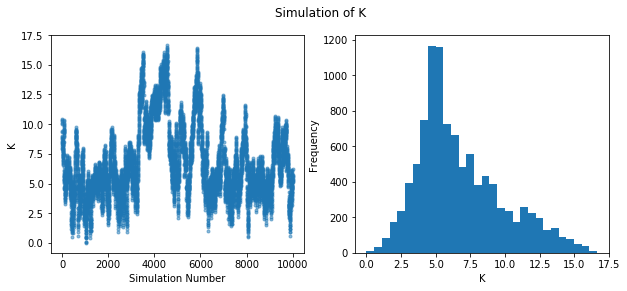

iteration : 10
mid_value : 6.46435546875


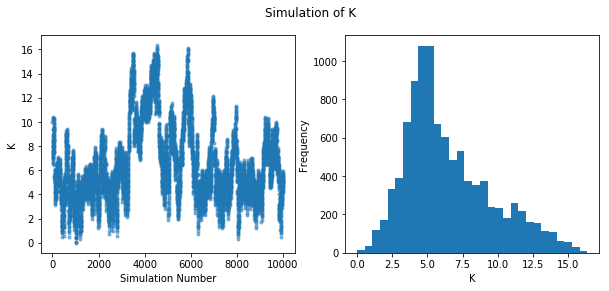

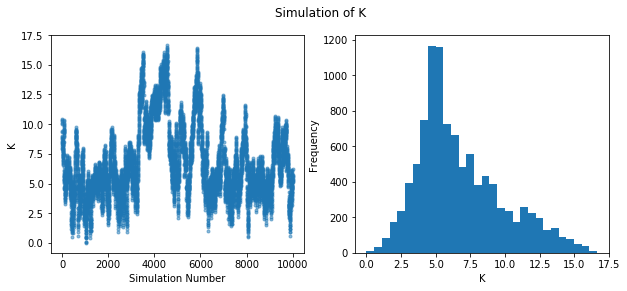

iteration : 11
mid_value : 6.459716796875


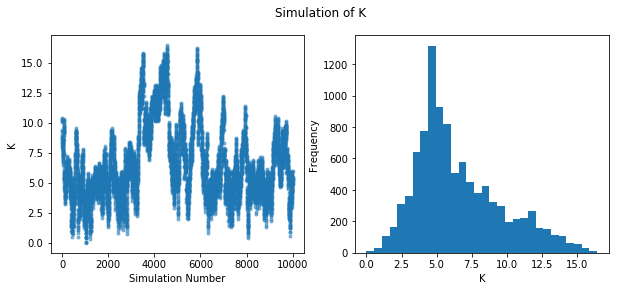

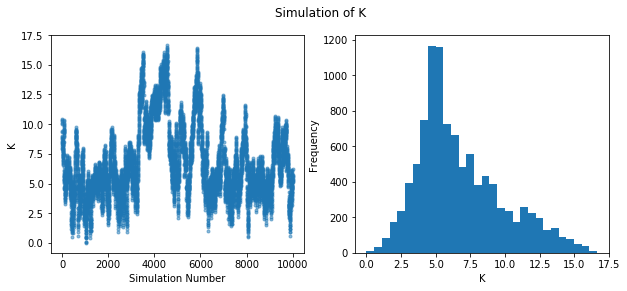

iteration : 12
mid_value : 6.4620361328125


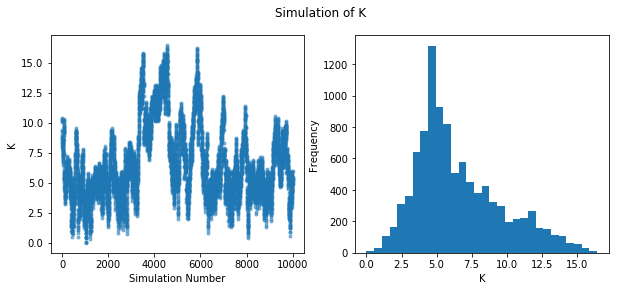

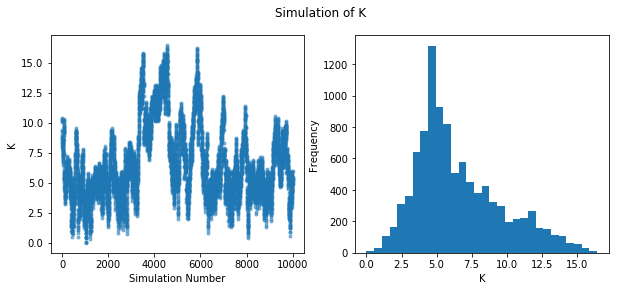

iteration : 13
mid_value : 6.46319580078125


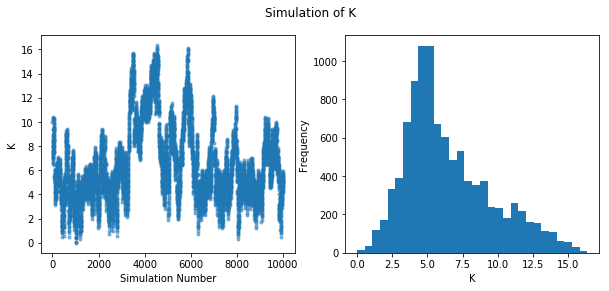

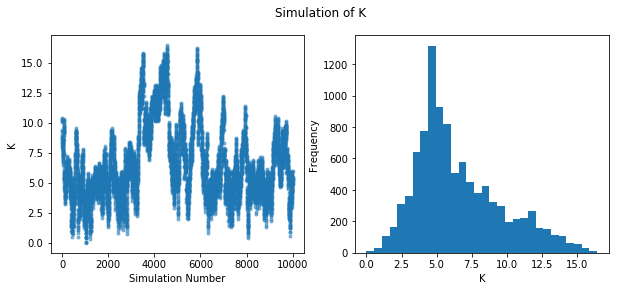

iteration : 14
mid_value : 6.462615966796875


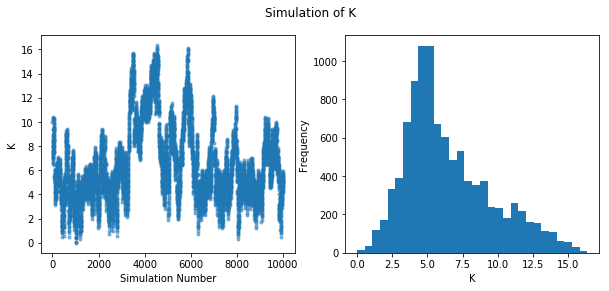

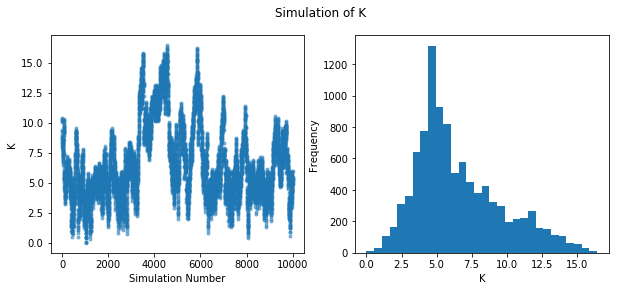

iteration : 15
mid_value : 6.4623260498046875


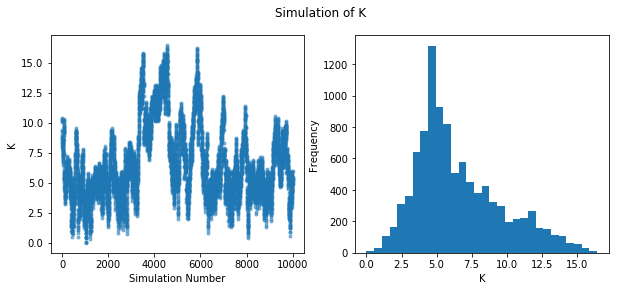

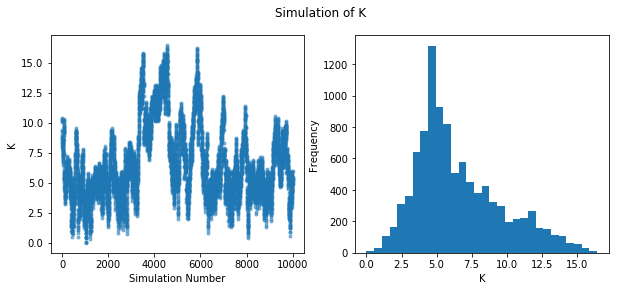

iteration : 16
mid_value : 6.462471008300781


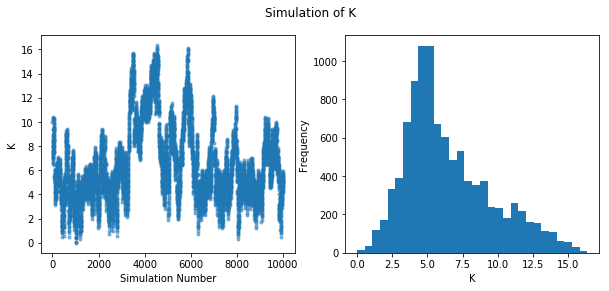

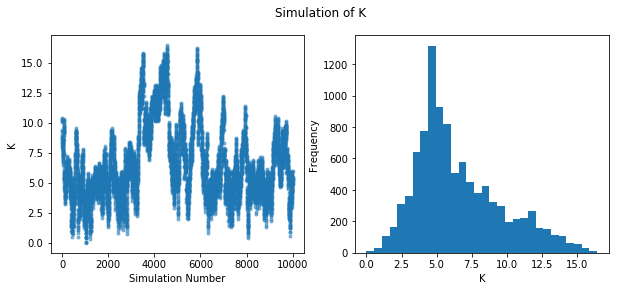

iteration : 17
mid_value : 6.462398529052734


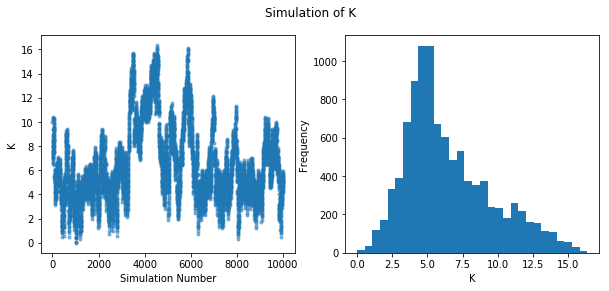

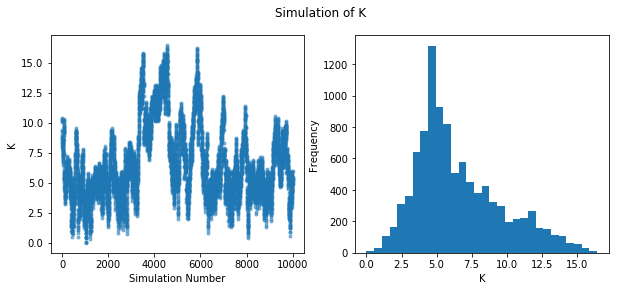

iteration : 18
mid_value : 6.462362289428711


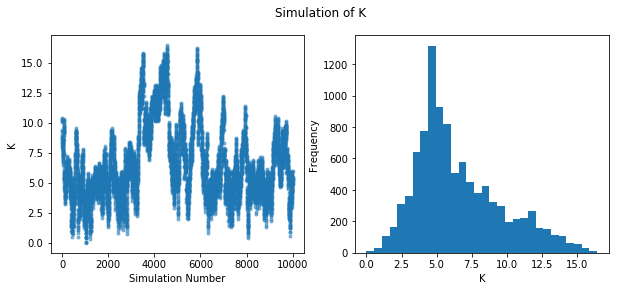

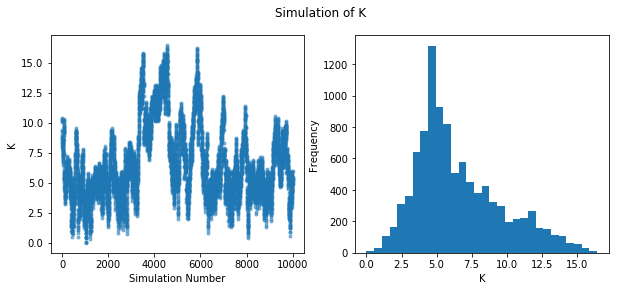

iteration : 19
mid_value : 6.462380409240723


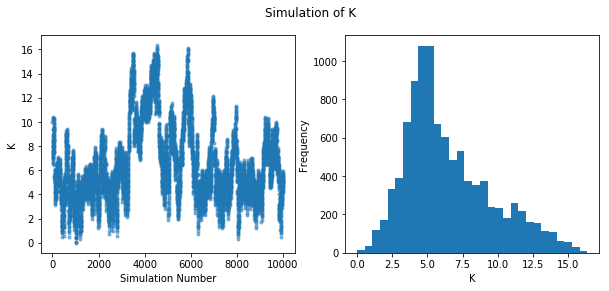

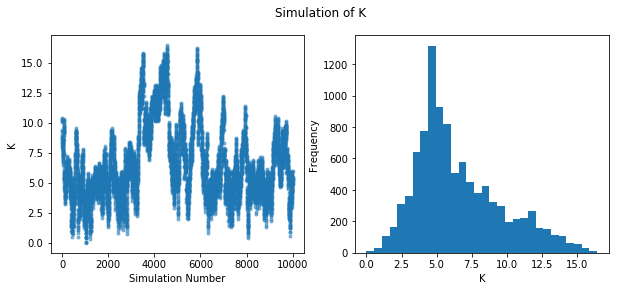

iteration : 20
mid_value : 6.462371349334717


In [24]:
k_a = 1
k_b = 20
T = 10000
k_bar_star = solve_k_bar(k_a, k_b, T)

In [25]:
k_bar_star

6.462371349334717

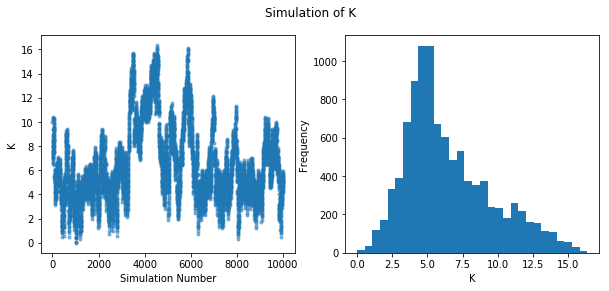

-0.012439844823437518

In [26]:
k_bar_err(k_bar_star, 10000)

## Solutions

### (i) optimal decision rule 

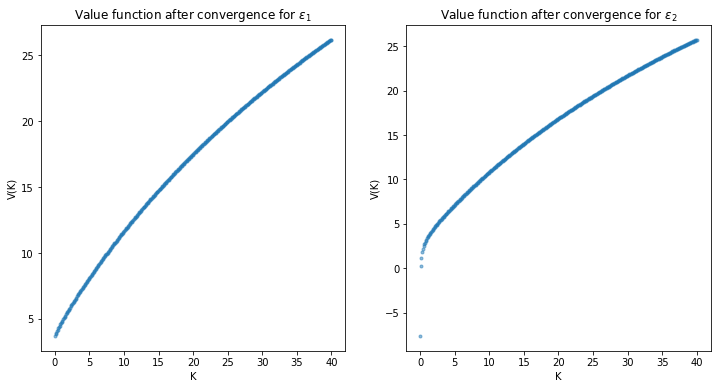

In [27]:
V1, V2 = solve_value_func_iter(k_bar_star)
fig, axes = plt.subplots(1, 2, figsize=(12,6))
        
axes[0].scatter(k_grid, V1, alpha=0.5, marker='.')
axes[0].set_xlabel("K")
axes[0].set_ylabel("V(K)")
axes[0].set_title('Value function after convergence for $\epsilon_1$')

axes[1].scatter(k_grid, V2, alpha=0.5, marker='.')
axes[1].set_xlabel("K")
axes[1].set_ylabel("V(K)")
axes[1].set_title('Value function after convergence for $\epsilon_2$')

plt.show()

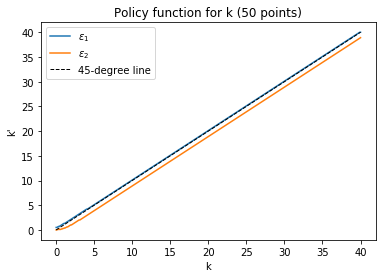

In [28]:
p_k1, p_k2 = extract_policy(V1, V2, k_bar_star)
plt.plot(k_grid, p_k1, '-', label = '$\epsilon_1$')
plt.plot(k_grid, p_k2, '-', label = '$\epsilon_2$')
plt.plot(k_grid, k_grid, color='black', linewidth=1, linestyle='--',
                 label='45-degree line')
plt.xlabel('k')
plt.ylabel("k'")
plt.title("Policy function for k (50 points)")
plt.legend(loc='upper left')
plt.show()

### (ii) Coefficient of variation of capital holdings in invariant distribution

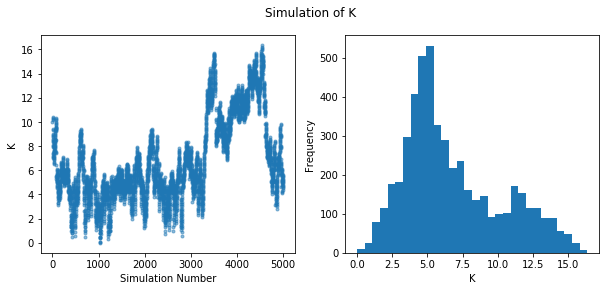

In [29]:
T = 5000
eps_sim = simulate_eps(T)
k_sim = simulate_k(p_k1, p_k2, eps_sim, T, plot=True)

In [30]:
k_sim_mean = k_sim.mean()
k_sim_std = k_sim.std()

In [31]:
CV = k_sim_std / k_sim_mean
print(CV)

0.5084716956653578


### (iV) Comparison of interest rates from neoclassical growth with complete markets and representative agents

In [32]:
r_rep_ss = get_r(k_rep_ss)
print("Representative agent model k: ", k_rep_ss)
print("Representative agent model r: ", r_rep_ss)

Representative agent model k:  7.211176392599507
Representative agent model r:  0.09503723459520197


In [33]:
r_ss = get_r(k_bar_star)
print("This economy k: ", k_bar_star)
print("This economy r: ", r_ss)

This economy k:  6.462371349334717
This economy r:  0.1019452239264216


#### (Comment)
According to theory, since agents in this economy have labor shocks, they are more willing to accumulate capital and save (precautionary savings). This would lead to lower interest rates. However, my results show that interest rate is higher in this economy than in the usual neoclassical groth with complete markets and a representative agent. This could be partly explained by the policy functions. When unemployed, even if want to accumulate capital and save, agent cannot as the policy function for $\epsilon_2$ is always below the 45 degree line. 